# XGBoost Model for Housing Price Prediction

## Project Overview

This notebook implements the XGBoost model for predicting housing prices using the Ames Housing dataset.
The model architecture and training setup follow the original pipeline from the research paper.

**Paper:** *Predicting housing prices and analyzing real estate markets in the Chicago suburbs using machine learning*  
**GitHub Repository:** [https://github.com/GeometricBison/HousePriceML](https://github.com/GeometricBison/HousePriceML)  




## Model Evaluation — Regression Metrics

The paper evaluates models using standard regression metrics:
- **RMSE (Root Mean Squared Error)**
- **R² Score**
- **MAE (Mean Absolute Error)**

To gain deeper insight, I additionally computed:
- **MSE (Mean Squared Error)**

These metrics measure how well the model predicts continuous house prices.


In [84]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import pickle

In [85]:
df = pd.read_csv("data/train.csv")

In [86]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Table 1 — Averages of Housing Variables

This table summarizes the average values of the selected housing attributes from the Ames dataset.  
These variables are the closest equivalents to those used in the research paper.

They represent general property characteristics. Although the original paper observed an increase in price and 
tax amount over years (2018–2022 Chicago data), the Ames dataset spans 2006–2010, so the patterns differ.

However, this table still helps understand typical property features before modeling.

In [87]:
table_cols = [
    "SalePrice",
    "YearBuilt",
    "GarageCars",
    "BedroomAbvGr",
    "FullBath",
    "GrLivArea",
    "TotalBsmtSF",
    "TotRmsAbvGrd"
]

table1 = df[table_cols].mean().to_frame("Average Value")
table1

,Average Value
SalePrice,180921.195890
YearBuilt,1971.267808
GarageCars,1.767123
BedroomAbvGr,2.866438
FullBath,1.565068
GrLivArea,1515.463699
TotalBsmtSF,1057.429452
TotRmsAbvGrd,6.517808


## Figure 1 — Heatmap of Housing Variables

This heatmap visualizes the correlation between key housing features and SalePrice.

Darker red squares indicate a stronger positive relationship with house price, while blue tones show negative relations.  
Similar to the findings of the research paper, the strongest predictors include:

- **GrLivArea (Above-ground living area)**
- **GarageCars**
- **TotalBsmtSF**
- **FullBath**
- **TotRmsAbvGrd**

These relationships help confirm that size, quality, and major structural features are strongly tied to property value.

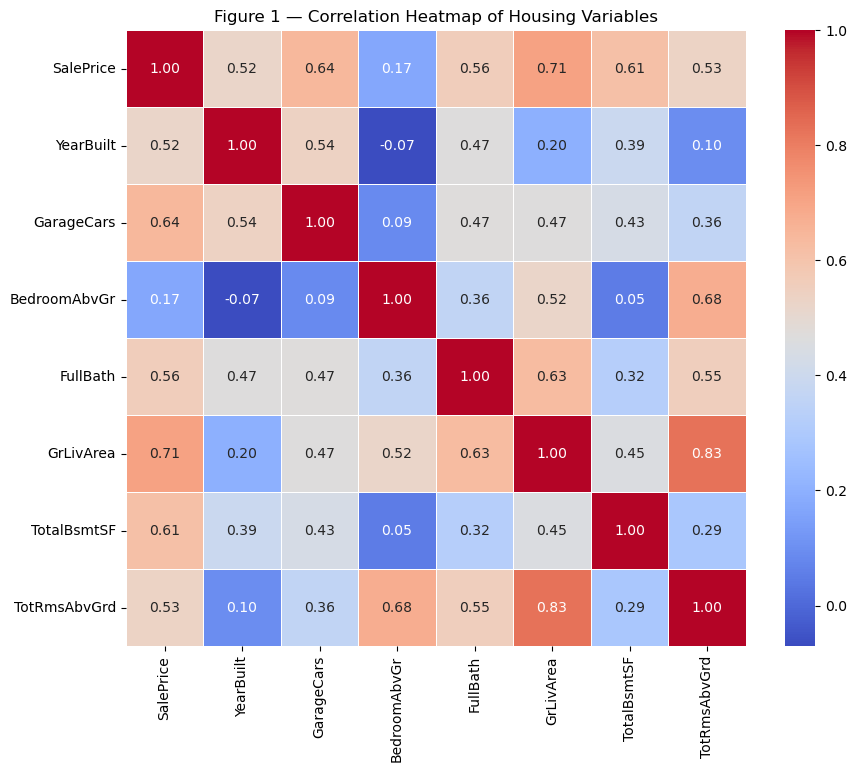

In [88]:
heatmap_cols = [
    "SalePrice",
    "YearBuilt",
    "GarageCars",
    "BedroomAbvGr",
    "FullBath",
    "GrLivArea",
    "TotalBsmtSF",
    "TotRmsAbvGrd"
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[heatmap_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Figure 1 — Correlation Heatmap of Housing Variables")
plt.show()

In [89]:
target_col = "SalePrice"
y = df[target_col]
X = df.drop(columns=[target_col])

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.mean(numeric_only=True))

print("Full feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Full feature matrix shape: (1460, 245)
Target shape: (1460,)


In [90]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=69
)

print("Train X:", train_X.shape)
print("Test X:", test_X.shape)

Train X: (1168, 245)
Test X: (292, 245)


## Base XGBoost Regressor

As in the paper, I start with a base `XGBRegressor` and then apply hyperparameter search:

- First: `GridSearchCV` over a small grid
- Second: `RandomizedSearchCV` over a refined parameter space

Both use cross-validation on the training data.


In [91]:
xgb_model = xgb.XGBRegressor()
xgb_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Grid Search Hyperparameter Tuning

The paper first runs a **Grid Search** over a small hyperparameter grid, for example:

- `nthread`: [1, 10, 20]
- `objective`: `reg:gamma`
- `learning_rate`: [0.1]
- `max_depth`: [4]
- `min_child_weight`: [4]
- `n_estimators`: [325]
- `subsample`: [1]
- `gamma`: [0]
- `alpha`: [0]

Here, I use the same style of grid on the Ames feature matrix.

The best model from this grid search is used as an intermediate tuned model.

In [92]:
param_grid = {
    "nthread": [1, 10, 20],
    "objective": ["reg:gamma"],
    "learning_rate": [0.1],
    "max_depth": [4],
    "min_child_weight": [4],
    "n_estimators": [325],
    "subsample": [1],
    "gamma": [0],
    "alpha": [0],
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3,
    scoring="neg_mean_squared_error",
)

grid_search.fit(train_X, train_y)
best_regressor_grid = grid_search.best_estimator_
best_regressor_grid

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,objective,'reg:gamma'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


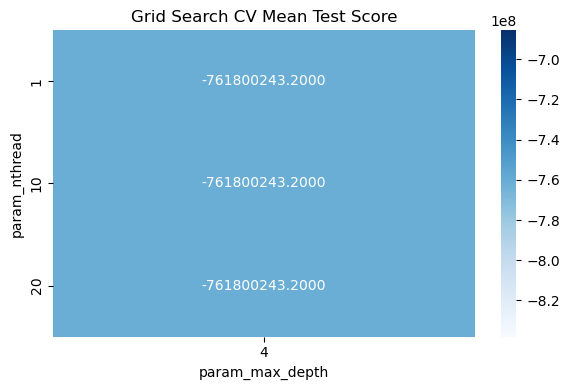

In [93]:
cv_results_grid = pd.DataFrame(grid_search.cv_results_)
pivot_grid = pd.pivot_table(
    cv_results_grid,
    values="mean_test_score",
    index="param_nthread",
    columns="param_max_depth",
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_grid, annot=True, fmt=".4f", cmap="Blues")
plt.title("Grid Search CV Mean Test Score")
plt.tight_layout()
plt.show()

In [94]:
param_dist = {
    "nthread": [30, 35, 45],
    "max_depth": [5, 6],
    "learning_rate": [0.1],
    "subsample": [0.9],
    "objective": ["reg:gamma"],
    "colsample_bytree": [0.9],
    "min_child_weight": [4, 5, 6],
    "colsample_bylevel": [0.8],
    "n_estimators": [300],
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring="neg_mean_squared_error",
    n_iter=25,
    verbose=3,
    n_jobs=-1,
    cv=5,
    random_state=42,
)

random_search.fit(train_X, train_y)
best_regressor = random_search.best_estimator_
best_regressor

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,objective,'reg:gamma'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.8
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


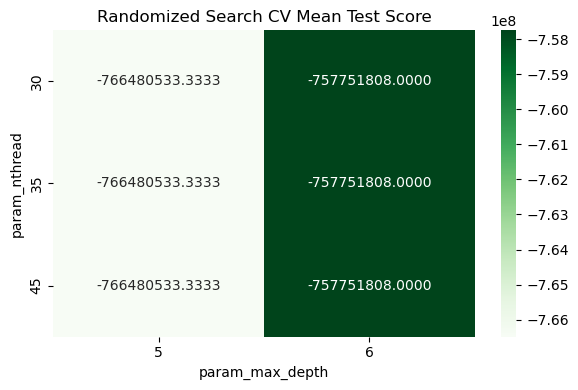

In [95]:
cv_results_rand = pd.DataFrame(random_search.cv_results_)
pivot_rand = pd.pivot_table(
    cv_results_rand,
    values="mean_test_score",
    index="param_nthread",
    columns="param_max_depth",
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_rand, annot=True, fmt=".4f", cmap="Greens")
plt.title("Randomized Search CV Mean Test Score")
plt.tight_layout()
plt.show()

In [96]:
filename = "xgboost_ames_final.pkl"
with open(filename, "wb") as f:
    pickle.dump(best_regressor, f)

In [97]:
with open("xgboost_ames_final.pkl", "rb") as f:
    loaded_regressor = pickle.load(f)

loaded_regressor

,objective,'reg:gamma'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.8
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [98]:
y_test_pred = loaded_regressor.predict(test_X)
y_train_pred = loaded_regressor.predict(train_X)

test_mae = mean_absolute_error(test_y, y_test_pred)
test_rmse = mean_squared_error(test_y, y_test_pred) ** 0.5
test_r2 = r2_score(test_y, y_test_pred)

train_mae = mean_absolute_error(train_y, y_train_pred)
train_rmse = mean_squared_error(train_y, y_train_pred) ** 0.5
train_r2 = r2_score(train_y, y_train_pred)

print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)
print()
print("Train MAE:", train_mae)
print("Train RMSE:", train_rmse)
print("Train R²:", train_r2)

Test MAE: 16917.548828125
Test RMSE: 26074.023855170493
Test R²: 0.886721670627594

Train MAE: 1030.3609619140625
Train RMSE: 1492.5590440582241
Train R²: 0.9996508955955505


In [105]:
test_mse = mean_squared_error(test_y, y_test_pred)
train_mse = mean_squared_error(train_y, y_train_pred)

print("Test MSE:", test_mse)
print("Train MSE:", train_mse)

Test MSE: 679854720.0
Train MSE: 2227732.5


According to the SHAP values, the model relies most heavily on the following features when predicting **SalePrice**:

- **OverallQual** — Overall material and finish quality  
- **GrLivArea** — Above-ground living area  
- **TotalBsmtSF** — Total basement square footage  
- **BsmtFinSF1** — Finished basement area (Type 1)  
- **GarageCars** — Garage capacity (number of cars)  
- **LotArea** — Lot size  
- **YearRemodAdd** — Year the house was remodeled  
- **1stFlrSF** — First-floor living area  
- **Fireplaces** — Number of fireplaces  
- **OverallCond** — Overall condition rating
These appear at the top of the SHAP plot, indicating highest importance.

## Key Interpretation

The SHAP summary plot provides a clear interpretation of how the CatBoost/XGBoost model makes pricing decisions. Based on the plot, the following conclusions can be made:

- **The most influential features are OverallQual, GrLivArea, TotalBsmtSF, GarageCars, and BsmtFinSF1.**  
  These features have the largest SHAP magnitudes, meaning the model relies on them the most to predict SalePrice.

- **High values of the key features increase SalePrice, while low values decrease it.**  
  - Houses with **high OverallQual** show strong positive SHAP values → significantly higher predicted prices.  
  - Larger **GrLivArea** and **TotalBsmtSF** also push predictions upward.  
  - Low values of these features correspond to negative SHAP values → lower predicted prices.

- **The effect of each feature is consistent across the dataset.**  
  For example, almost all points for **OverallQual** show the same directional impact:  
  - High-quality homes raise price  
  - Low-quality homes reduce price  
This indicates the model learned stable, non-random relationships.

- **The model's learned patterns match real-world housing behavior.**  
  The top features (quality, size, basement area, garage capacity) are exactly the factors that drive housing prices in real markets.  
  This alignment shows that the model is not overfitting to noise—it captures meaningful economic patterns.


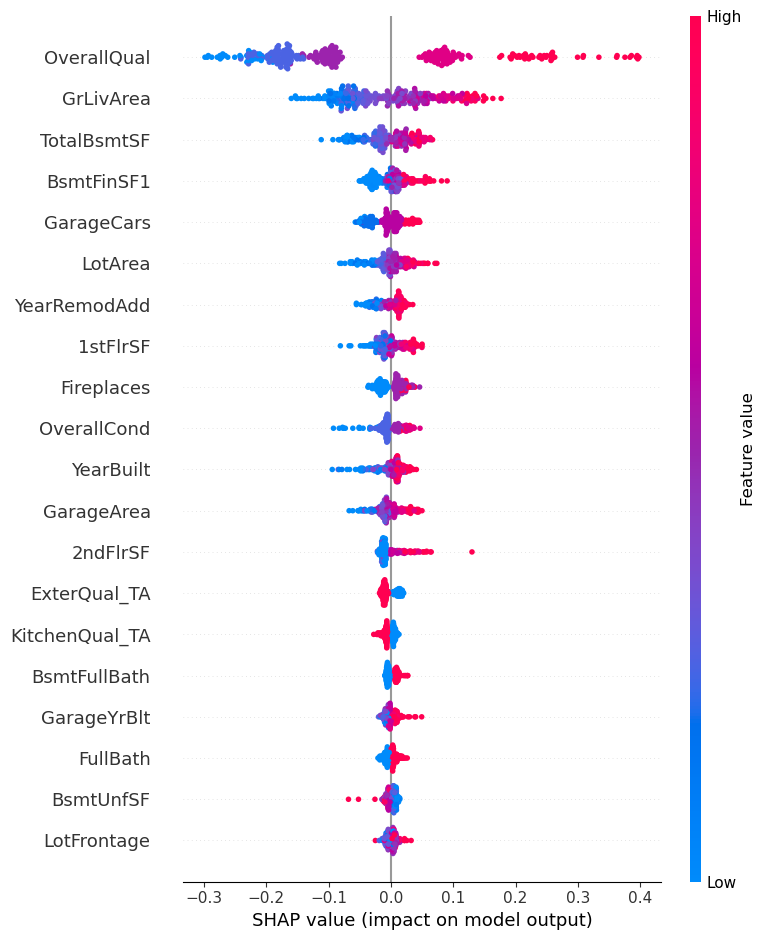

In [108]:
explainer = shap.TreeExplainer(best_regressor)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

## My Additional Evaluation & Analysis

### 1. Price Category Classification (My Extension)

To interpret predictions more intuitively, I bin `SalePrice` into three categories:

- **Low**
- **Mid**
- **High**

Then I compare actual vs predicted bins using:

- Accuracy
- Precision
- Recall
- F1-score
- Classification report
- Confusion matrix heatmap

### 2. Visual Analysis

To better understand model behavior, I generate:

- **Actual vs Predicted** scatter plot  
- **Residuals vs Predicted** plot  
- **Residual distribution** histogram  

These help reveal under/over-prediction patterns and potential heteroscedasticity.


In [100]:
y_true = test_y.values
y_pred = y_test_pred

true_bins = pd.qcut(y_true, q=3, labels=["Low", "Mid", "High"])
pred_bins = pd.qcut(y_pred, q=3, labels=["Low", "Mid", "High"])

acc = accuracy_score(true_bins, pred_bins)
prec = precision_score(true_bins, pred_bins, average="weighted")
rec = recall_score(true_bins, pred_bins, average="weighted")
f1 = f1_score(true_bins, pred_bins, average="weighted")

print("Price Category Metrics (Low / Mid / High):")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print()
print("Classification Report:")
print(classification_report(true_bins, pred_bins))

Price Category Metrics (Low / Mid / High):
Accuracy: 0.863013698630137
Precision: 0.863013698630137
Recall: 0.863013698630137
F1-score: 0.863013698630137

Classification Report:
              precision    recall  f1-score   support

        High       0.90      0.90      0.90        97
         Low       0.89      0.89      0.89        98
         Mid       0.80      0.80      0.80        97

    accuracy                           0.86       292
   macro avg       0.86      0.86      0.86       292
weighted avg       0.86      0.86      0.86       292



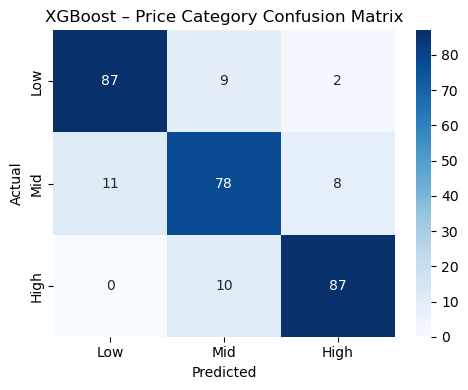

In [101]:
labels = ["Low", "Mid", "High"]
cm = confusion_matrix(true_bins, pred_bins, labels=labels)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost – Price Category Confusion Matrix")
plt.tight_layout()
plt.show()

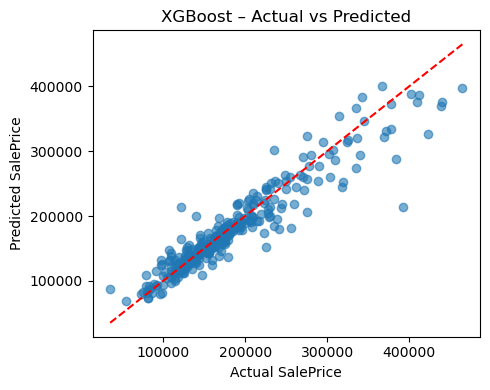

In [102]:
plt.figure(figsize=(5, 4))
plt.scatter(y_true, y_pred, alpha=0.6)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red",linestyle="--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost – Actual vs Predicted")
plt.tight_layout()
plt.show()

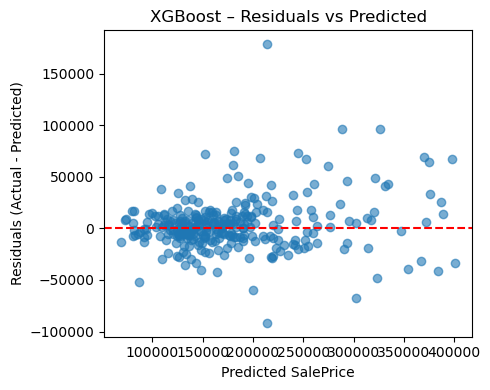

In [103]:
residuals = y_true - y_pred

plt.figure(figsize=(5, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("XGBoost – Residuals vs Predicted")
plt.tight_layout()
plt.show()

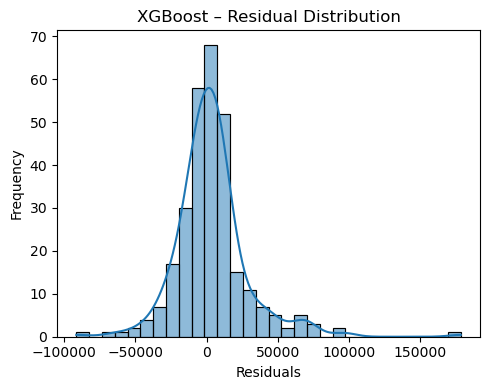

In [104]:
plt.figure(figsize=(5, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("XGBoost – Residual Distribution")
plt.tight_layout()
plt.show()